<a href="https://colab.research.google.com/github/mileslilly2/code_for_whatever_you_are/blob/main/Copy_of_how_to_paint_with_python_and_proccessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title (Optional) Factory reset Colab runtime
# This is handy if you've already installed conflicting versions
!pip install -q --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.3 MB/s eta 0:00:00


In [ ]:
# Monet Deep-Stroke Extractor  ★ single-notebook version
# ╔═════════════════ 0. Install & imports ═════════════════╗
!pip -q install torch torchvision --upgrade
!pip -q install opencv-python-headless scikit-image shapely tqdm matplotlib

import json, math, urllib.request, os, random, io, numpy as np, cv2
import matplotlib.pyplot as plt
from skimage import morphology, feature, color
from shapely.geometry import LineString
import torch, torchvision
from torchvision import transforms
from tqdm.auto import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

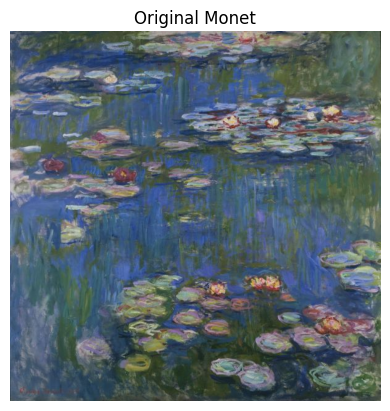

In [ ]:
# ╔═════════════════ 1. Grab a Monet & display ═════════════╗
IMG_URL = "https://upload.wikimedia.org/wikipedia/commons/5/5d/Monet_Water_Lilies_1916.jpg"
urllib.request.urlretrieve(IMG_URL, "monet.jpg")
orig = cv2.cvtColor(cv2.imread("monet.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(orig); plt.axis("off"); plt.title("Original Monet");


In [ ]:
# ╔═════════════════ 2. VGG-19 hooks for deep feature maps ═════════════╗
vgg = torchvision.models.vgg19(weights="VGG19_Weights.DEFAULT").features.eval()

layers = {"conv1_1":0, "conv2_1":5, "conv3_1":10, "conv4_1":19}
acts = {}
for name, idx in layers.items():
    vgg[idx].register_forward_hook(lambda m, i, o, n=name: acts.update({n:o}))

prep = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
x = prep(orig).unsqueeze(0)
_ = vgg(x)                       # forward pass


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 75.2MB/s]


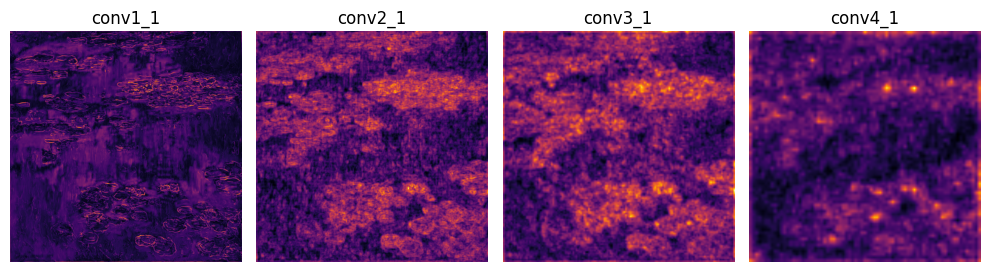

In [ ]:
# ╔═════════════════ 3. Visualise selected feature maps ═══════════════╗
plt.figure(figsize=(10,3))
for k, fmap in acts.items():
    ch = fmap[0].mean(0).detach().cpu().numpy()
    ch = (ch - ch.min())/(np.ptp(ch)+1e-5)
    plt.subplot(1,len(acts), list(acts).index(k)+1)
    plt.imshow(cv2.resize(ch, orig.shape[:2][::-1]), cmap='inferno')
    plt.axis("off"); plt.title(k);
plt.tight_layout();


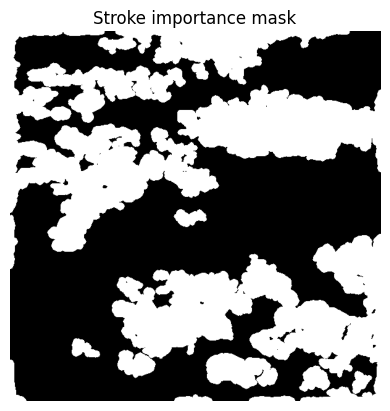

In [ ]:
# ╔═════════════════ 4. Fuse feature maps → importance mask ═══════════╗
# Simple fusion: mean of (conv2_1 + conv3_1 + conv4_1), then threshold
fused = sum(cv2.resize(acts[l][0].mean(0).detach().cpu().numpy(),
                       orig.shape[:2][::-1]) for l in ["conv2_1","conv3_1","conv4_1"])
fused = (fused - fused.min())/(np.ptp(fused)+1e-5)


th = np.percentile(fused, 65)            # keep salient regions
mask = morphology.remove_small_objects((fused>th), min_size=200)
mask = morphology.dilation(mask, morphology.disk(3))

plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title("Stroke importance mask");


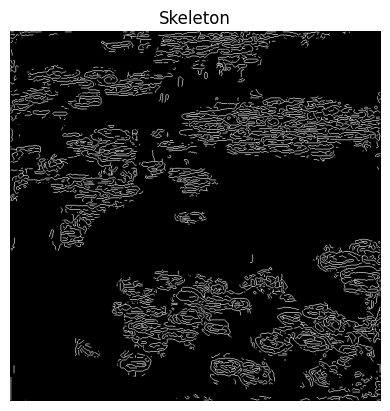

In [ ]:
# ╔═════════════════ 5. Edge refine & skeletonise ════════════════╗
edges = feature.canny(color.rgb2gray(orig), sigma=1)
stroke_mask = morphology.skeletonize(mask & edges)

plt.imshow(stroke_mask, cmap='gray'); plt.axis('off'); plt.title("Skeleton");


In [ ]:
# ╔═════════════════ 6. Extract polylines, fit cubic Béziers ══════════╗
def rdp(pts, eps=2.5):
    if len(pts)<3: return pts
    return np.asarray(LineString(pts).simplify(eps).coords, np.float32)

def poly_to_beziers(poly):
    # chunk polyline into groups of 4 points
    return [poly[i:i+4] for i in range(0, len(poly)-1, 3) if len(poly[i:i+4])==4]

contours, _ = cv2.findContours(stroke_mask.astype(np.uint8), cv2.RETR_LIST,
                               cv2.CHAIN_APPROX_NONE)

strokes = []
for cnt in tqdm(contours, desc="fit"):
    pts = cnt[:,0,::-1]               # swap to (x,y)
    pts = rdp(pts)
    for bez in poly_to_beziers(pts):
        (x0,y0) = map(int, bez[0])
        r,g,b = orig[y0%orig.shape[0], x0%orig.shape[1]]
        strokes.append({
            "points":[ [float(x),float(y)] for x,y in bez ],
            "width": 3+2*random.random(),
            "color":[int(r),int(g),int(b)],
            "opacity":0.88
        })

print("Strokes:", len(strokes))


fit:   0%|          | 0/1383 [00:00<?, ?it/s]

Strokes: 5100


In [ ]:
# ╔══════════ 7. (Optional) tiny neural-painter refinement ════════════╗
# Skip if you just want quick output.  Set DO_REFINE=False to disable.
DO_REFINE = False
if DO_REFINE:
    # simple heuristic: sort strokes by their mask importance (coarse→fine)
    def importance(s):
        x,y = map(int, s["points"][0])
        return fused[y%fused.shape[0], x%fused.shape[1]]
    strokes = sorted(strokes, key=importance)   # paint background first


In [ ]:
# ╔═════════════════ 8. Save & download JSON ═══════════════════════════╗
with open("monet_strokes.json", "w") as f: json.dump(strokes, f, indent=2)

from google.colab import files; files.download("monet_strokes.json")
print("✓  JSON ready.  Drop into the Processing sketch and press Play!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓  JSON ready.  Drop into the Processing sketch and press Play!
